In [1]:
import glob
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import datetime
from typing import Union, List, Tuple
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Input, Dense, Activation)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_probability as tfp
import seaborn as sns

pi = math.pi
maxval = 1e9
minval = 1e-9

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [3]:
def inverse_cot(cota):
    a = np.arctan(1/cota)
    a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [4]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = inverse_cot(abs(train_df['cotBeta'].values))/(pi/2)
y_test = inverse_cot(abs(test_df['cotBeta'].values))/(pi/2)

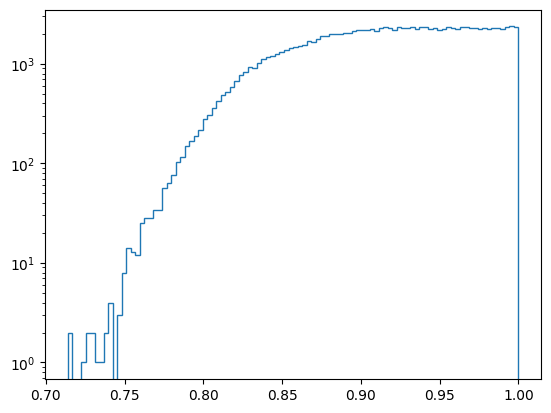

In [5]:
plt.hist(y_train,bins = 100, histtype = "step");
plt.yscale("log")
plt.show()

In [6]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])
print(X_train.shape,X_test.shape)

(126119, 13) (24657, 13)


In [7]:
def param_transform(par):
    return minval+tf.math.softplus(par)

def log_beta(x, alpha, beta):
    # x in (0, 1), alpha > 0, beta > 0
    return (alpha - 1.)*tf.math.log(x) + (beta - 1.)*tf.math.log(1 - x) \
            - tf.math.lgamma(alpha) - tf.math.lgamma(beta) + tf.math.lgamma(alpha + beta)

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
#     dist = tfp.distributions.Beta(concentration1 = alpha,
#                                   concentration0 = beta)
    
#     likelihood = dist.prob(y)  
#     likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*log_beta(y, alpha, beta)
    return tf.keras.backend.sum(NLL,axis=1)    

In [8]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("elu", name="elu1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("elu", name="elu2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("elu", name= "elu3")(x)
    x = BatchNormalization()(x)
    x = Dense(2, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.00125),
              loss=beta_loss)

print(model.summary())

es = EarlyStopping(patience=20,
                  restore_best_weights=True)
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=25, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=True)

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 elu1 (Activation)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 elu2 (Activation)           (None, 64)                0         
                               

2023-02-14 09:20:54.404913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 09:20:54.404935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-14 09:20:54.594758: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-14 09:20:55.012570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1577/1577 [==============================] - ETA: 0s - loss: -1.7420

2023-02-14 09:21:26.312616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1577/1577 [==============================] - 34s 21ms/step - loss: -1.7420 - val_loss: -2.1539
Epoch 2/25
1577/1577 [==============================] - 32s 20ms/step - loss: -2.2362 - val_loss: -2.2748
Epoch 3/25
1577/1577 [==============================] - 31s 20ms/step - loss: -2.3175 - val_loss: -2.3511
Epoch 4/25
1577/1577 [==============================] - 29s 19ms/step - loss: -2.3615 - val_loss: -2.3967
Epoch 5/25
1577/1577 [==============================] - 29s 19ms/step - loss: -2.3913 - val_loss: -2.4363
Epoch 6/25
1577/1577 [==============================] - 29s 18ms/step - loss: -2.4213 - val_loss: -2.3895
Epoch 7/25
1577/1577 [==============================] - 29s 18ms/step - loss: -2.4363 - val_loss: -2.3863
Epoch 8/25
1577/1577 [==============================] - 29s 18ms/step - loss: -2.4543 - val_loss: -2.3652
Epoch 9/25
1577/1577 [==============================] - 29s 19ms/step - loss: -2.4697 - val_loss: -2.3292
Epoch 10/25
1577/1577 [==============================] - 

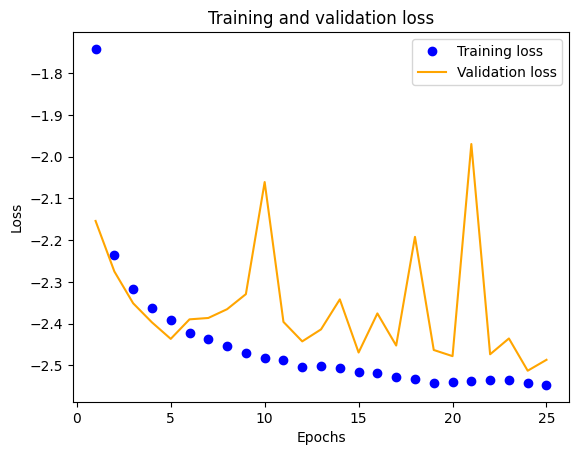

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [10]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Btrue'] = y_test*pi/2
df['alpha'] = param_transform(df['par1'])
df['beta'] = param_transform(df['par2'])

dist = tfp.distributions.Beta(concentration1 = df['alpha'], concentration0 = df['beta'])
    
df['mean'] = dist.mean()*pi/2
df['mode'] = dist.mode()*pi/2
df['sigma'] = dist.stddev()*pi/2

df.to_csv("test_1DcotBBeta.csv",header=False,index=False)

 17/771 [..............................] - ETA: 5s

2023-02-14 09:33:10.218597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


771/771 [==============================] - 3s 4ms/step


In [11]:
residuals = df['Btrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

-0.01993839497274905 0.03779157156017799


In [12]:
# plt.hist(residuals,bins=50)
# plt.yscale('Log')
# plt.xlabel(r'$\beta$ - mode [rad]')
# plt.show()

# plt.hist(df['sigma'],bins=np.linspace(0,0.3,50));
# plt.yscale('Log')
# plt.xlabel(r'$\sigma$ [rad]')
# plt.show()

# plt.hist(df['alpha'],bins=50)
# plt.yscale('Log')
# plt.xlabel(r'$\alpha$')
# plt.show()

# plt.hist(df['beta'],bins=50)
# plt.yscale('Log')
# plt.xlabel(r'$\beta$')
# plt.show()

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_2083/2827940454.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


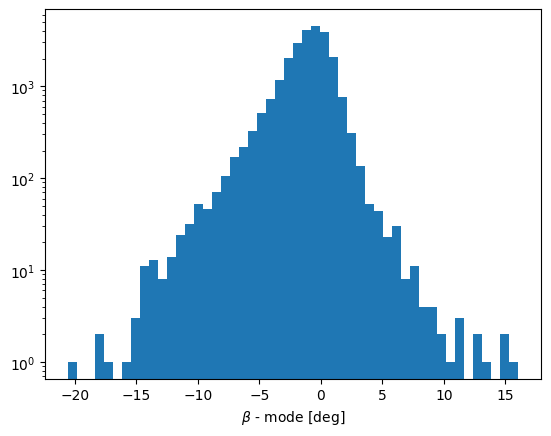

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_2083/2827940454.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


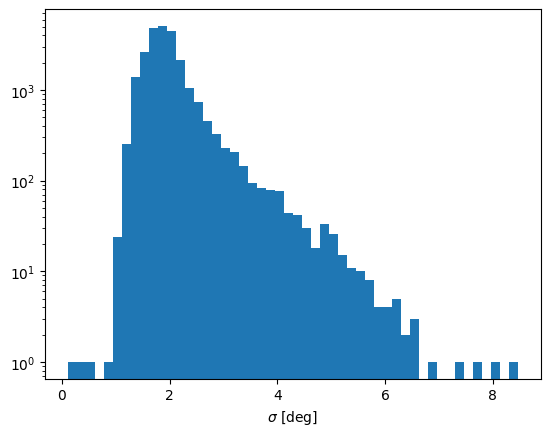

In [13]:
plt.hist(residuals*180/pi,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$ - mode [deg]')
plt.show()

plt.hist(df['sigma']*180/pi,bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [deg]')
plt.show()

Text(0, 0.5, 'log(beta)')

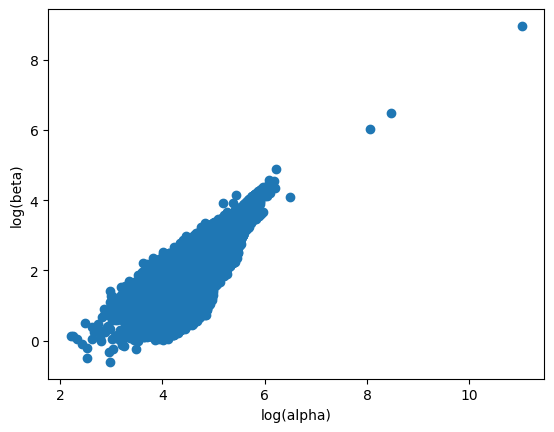

In [14]:
plt.scatter(np.log(df['alpha']),np.log(df['beta']))
plt.xlabel('log(alpha)')
plt.ylabel('log(beta)')

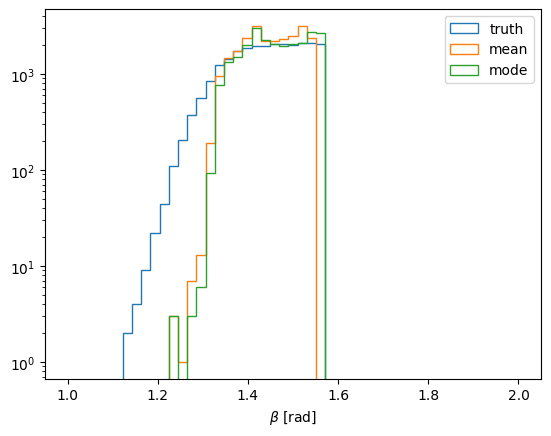

In [15]:
plt.hist(df['Btrue'],bins=np.linspace(1,2,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(1,2,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(1,2,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\beta$ [rad]')
plt.legend()
plt.yscale('log')
plt.show()

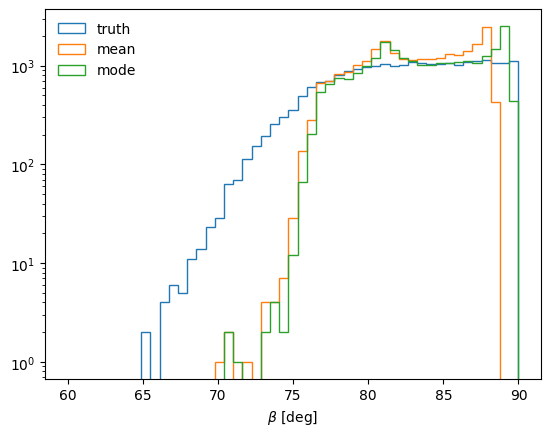

In [16]:
plt.hist(df['Btrue']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='truth')
plt.hist(df['mean']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='mean')
plt.hist(df['mode']*180/pi,bins=np.linspace(60,90,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\beta$ [deg]')
plt.legend(frameon=False,loc='upper left')
plt.yscale('log')
plt.show()

Text(0, 0.5, '$\\beta$ - mode [rad]')

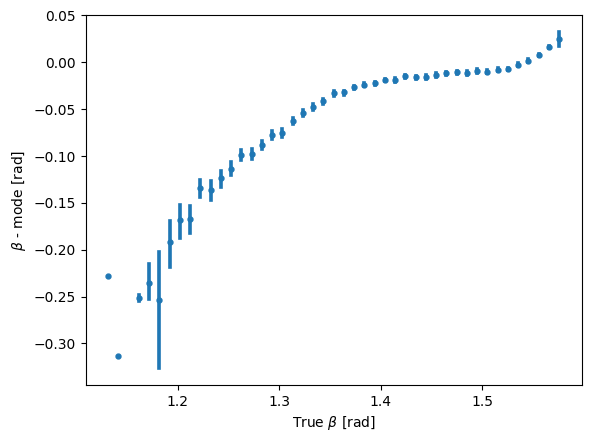

In [17]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mode'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\beta$ - mode [rad]')

Text(0, 0.5, '$\\beta$ - mode [deg]')

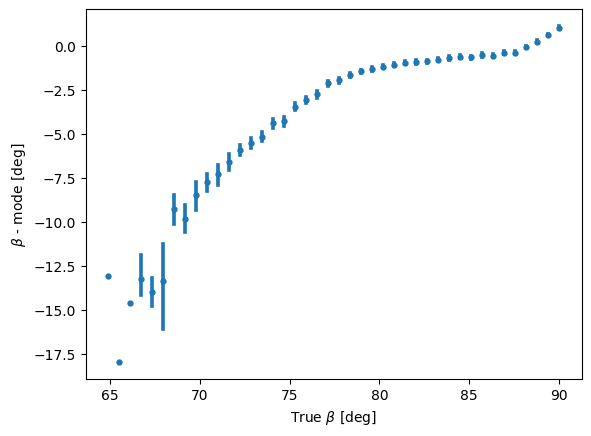

In [18]:
x = sns.regplot(x=df['Btrue']*180/pi, y=(df['Btrue']-df['mode'])*180/pi, x_bins=np.linspace(60,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\beta$ - mode [deg]')

Text(0, 0.5, '$\\beta$ - mode [rad]')

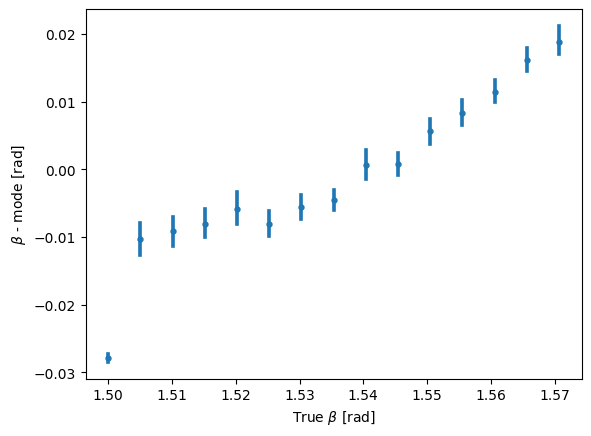

In [19]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mode'], x_bins=np.linspace(1.5,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\beta$ - mode [rad]')

Text(0, 0.5, '$\\beta$ - mode [deg]')

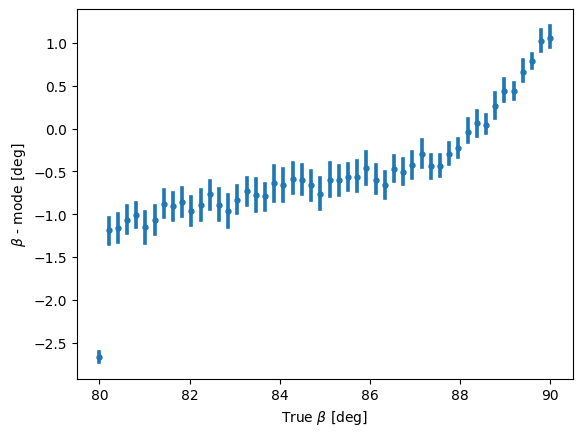

In [20]:
x = sns.regplot(x=df['Btrue']*180/pi, y=(df['Btrue']-df['mode'])*180/pi, x_bins=np.linspace(80,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\beta$ - mode [deg]')

Text(0, 0.5, '$\\sigma$ [rad]')

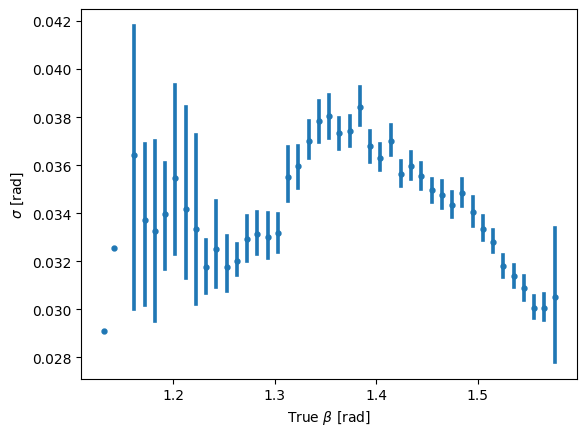

In [21]:
y = sns.regplot(x=df['Btrue'], y=df['sigma'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\sigma$ [rad]')

Text(0, 0.5, '$\\sigma$ [deg]')

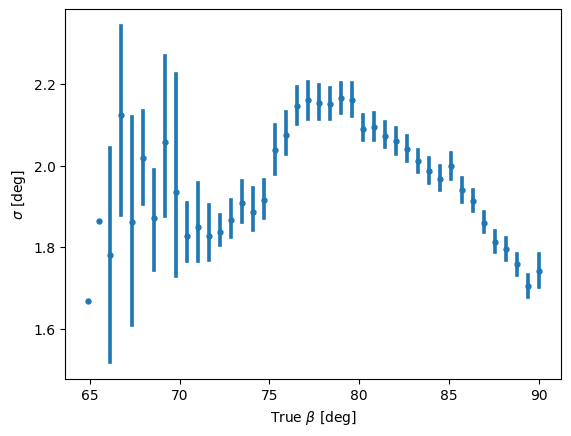

In [22]:
y = sns.regplot(x=df['Btrue']*180/pi, y=df['sigma']*180/pi, x_bins=np.linspace(60,90,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel(r'$\sigma$ [deg]')

In [23]:
pulls = residuals/df['sigma']

Text(0.5, 0, 'pull')

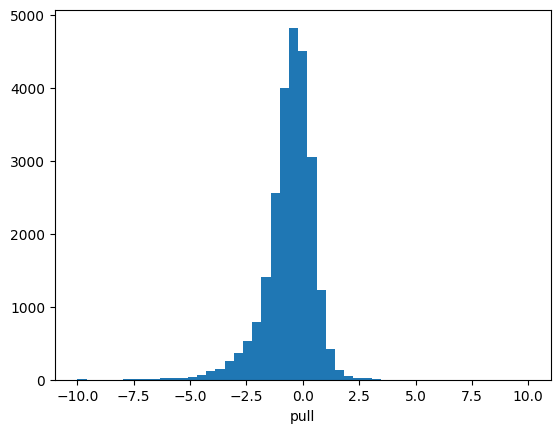

In [24]:
plt.hist(pulls,bins=np.linspace(-10,10,50));
plt.xlabel('pull')

In [25]:
print(np.mean(pulls),np.std(pulls))

-0.5839210151322004 1.1456993259200414
